In [1]:
import numpy as np
from gpcam import GPOptimizer

from numpy.random import default_rng

import pandas as pd

from scipy.optimize import minimize

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import os
import csv

import random

from sklearn.preprocessing import MinMaxScaler


In [2]:
# Plotting the results on a 3D plot
def plot(X, Y, Z, W ,W1, data=None, filename=None):

    axis_title_size = 40
    axis_ticks_size = 18

    fig = go.Figure()

    if data is not None:
        fig.add_trace(go.Scatter3d(
            x=data[:, 0],
            y=data[:, 1],
            z=data[:, 3],
            mode='markers',
            marker=dict(
                size=12,
                color=data[:, 4],
                opacity=0.8)
            ))

    for i in range(0, len(Z[0, 0, :]), 4):
        fig.add_trace(go.Surface(
            x=X[:, :, i],
            y=Y[:, :, i],
            z=Z[:, :, i],
            surfacecolor=W[:, :, i],
            cmin=np.min(W1),
            cmax=np.max(W1),
            colorbar=dict(
                title='Energy',
                tickvals=[round(np.min(W1)+0.01*np.min(W1), 2), round(np.max(W1)- 0.01*np.max(W1), 2)],
                #ticktext=['Min', 'Max'],
                ticks='outside',
                tickfont=dict(size=axis_ticks_size*2),
                len=0.8,  # Adjust the length of the color bar (0.5 represents half the length)
            )
        ))

    fig.update_layout(
        #title='Plot',
        autosize=True,
        width=1000,
        height=1000,
        margin=dict(l=65, r=50, b=65, t=90),
        scene=dict(
            xaxis_title='SOC',
            yaxis_title='C-rate',
            zaxis_title='Cycle',
            xaxis=dict(
                title_font=dict(size=axis_title_size),
                tickfont=dict(size=20),
                tickvals=np.linspace(20, 80, 4),  # Set the x-axis tick values (4 evenly spaced values)
                ticktext=np.array([20,40,60,80]),  # Set the x-axis tick labels (same as tick values)
                range=[20, 80],
             ),
            yaxis=dict(
                title_font=dict(size=axis_title_size),
                tickfont=dict(size=20),
                tickvals=np.linspace(2, 8, 4),  # Set the y-axis tick values (4 evenly spaced values)
                ticktext=np.array([2,4,6,8]),  # Set the y-axis tick labels (same as tick values)
                range=[2, 8],

            ),
            zaxis=dict(
                title_font=dict(size=axis_title_size),
                tickfont=dict(size=20),
                tickvals=np.linspace(10, 40, 4),  # Set the y-axis tick values (4 evenly spaced values)
                ticktext=np.array([10,20,30,40]),  # Set the y-axis tick labels (same as tick values)
                range=[0, 40],
            ),

        #camera=dict(
        #    eye=dict(x=2.5, y=2.5, z=2.5)  # Adjust these values to control zoom
        #)
      )

    )

    if filename is not None:
        # Use the write_image method to save the plot as a PDF
        fig.write_image(filename, format="pdf", engine="orca")
        
    fig.show()



# Plotting the results on a 3D plot
def plot_Uncertainty(X, Y, Z, W, W1, data=None, filename=None):
    fig = go.Figure()

    axis_title_size = 40
    axis_ticks_size = 18

    for i in range(0, len(Z[0, 0, :]),2):
        fig.add_trace(go.Surface(
            x=X[:, :, i],
            y=Y[:, :, i],
            z=Z[:, :, i],
            surfacecolor=W[:, :, i],
            cmin=0,
            cmax=np.max(W1),
            colorscale='Viridis',  # Set the Viridis colormap
            colorbar= dict(
                title=' ',
                tickvals=[round(np.min(W1)+ 0.05*np.min(W1),2), round(np.max(W1)- 0.02*np.max(W1),2)],
                #ticktext=['Min', 'Max'],
                ticks='outside',
                tickfont=dict(size=axis_ticks_size*2),
                len=0.8,  # Adjust the length of the color bar (0.5 represents half the length)
            )
        ))

    fig.update_layout(
        #title='Plot',
        autosize=True,
        width=1000,
        height=1000,
        margin=dict(l=65, r=50, b=65, t=90),
        scene=dict(
            xaxis_title='SOC',
            yaxis_title='C-rate',
            zaxis_title='Cycle',
            xaxis=dict(
                title_font=dict(size=axis_title_size),
                tickfont=dict(size=20),
                tickvals=np.linspace(20, 80, 4),  # Set the x-axis tick values (4 evenly spaced values)
                ticktext=np.array([20,40,60,80]),  # Set the x-axis tick labels (same as tick values)
                range=[20, 80],
             ),
            yaxis=dict(
                title_font=dict(size=axis_title_size),
                tickfont=dict(size=20),
                tickvals=np.linspace(2, 8, 4),  # Set the y-axis tick values (4 evenly spaced values)
                ticktext=np.array([2,4,6,8]),  # Set the y-axis tick labels (same as tick values)
                range=[2, 8],

            ),
            zaxis=dict(
                title_font=dict(size=axis_title_size),
                tickfont=dict(size=20),
                tickvals=np.linspace(10, 40, 4),  # Set the y-axis tick values (4 evenly spaced values)
                ticktext=np.array([10,20,30,40]),  # Set the y-axis tick labels (same as tick values)
                range=[0, 40],
            ),

        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5)  # Adjust these values to control zoom
        )
        )
    )


    if filename is not None:
        # Use the write_image method to save the plot as a PDF
        fig.write_image(filename, format="pdf", engine="orca")

    fig.show()


# Experimental Data

In [3]:
# Define the directory path containing the files
directory_path = r'/Users/MAlghalayini/Desktop/Codes/Experimental Data'

# List of temperature values
temperatures = ['285', '288', '291']  # Add more temperatures as needed
#temperatures = ['285']  # Add more temperatures as needed

# Create an empty DataFrame to store the combined data
combined_data_exp = pd.DataFrame()

my_cell_id_counter = 0

for temp in temperatures:
    # Load the "Fade_Rates_Table_{temp}.csv" file
    fade_rates_data = pd.read_csv(os.path.join(directory_path, f'Fade_Rates_Table_{temp}.csv'))

    # Loop through files in the directory for the current temperature
    for filename in os.listdir(directory_path):
        if filename.startswith(f"slow_cyclesDCW_AGE_{temp}K") and filename.endswith(".csv"):
            file_path = os.path.join(directory_path, filename)
        
            # Load data from the current file
            df = pd.read_csv(file_path)
        
            # Extract the desired response columns
            my_response = ['Discharge Energy (Wh)', 'Coulombic Efficiency']
            df_response = df[my_response]

            # Add SOC and C-rate data from fade_rates_data based on the index
            index_value = int(filename.split('-')[1].split('.')[0])  # Extract the index from the filename
        
            # Filter the "fade_rates_data" DataFrame to find the matching row
            filtered_data = fade_rates_data[fade_rates_data['Index'] == index_value]
            soc_value = filtered_data.iloc[0]['SOC [%]']
           
            crate_value = filtered_data.iloc[0]['C-rate']
            
            # Create a Series with repeated SOC values to match the number of rows in df_response
            soc_series = pd.Series([soc_value] * len(df_response), name='SOC [%]')

            # Create a Series with repeated C-rate values to match the number of rows in df_response
            crate_series = pd.Series([crate_value] * len(df_response), name='C-rate')

            # Create a Series with repeated Cell ID values to match the number of rows in df_response
            cellID_series = pd.Series([my_cell_id_counter] * len(df_response), name='Cell ID')
            
            # Concatenate df_response, soc_series, crate_series, and temp_series
            selected_data = pd.concat([df['Cycle'], df['Loop Number'], soc_series, crate_series,df['Temperature (K)'], df_response, cellID_series], axis=1)

            # Append current data to the combined_data DataFrame
            combined_data_exp = pd.concat([combined_data_exp, selected_data])

            my_cell_id_counter = my_cell_id_counter + 1

print(combined_data_exp.shape)

(1101, 8)


In [4]:
# Define the directory path containing the files
directory_path = r'/Users/MAlghalayini/Desktop/Codes/Experimental Data/Repeated Experiment at 291'

# Create an empty DataFrame to store the combined data
new_to_combine_data = pd.DataFrame()

this_soc = 30
this_crate = 7.46

# Loop through files in the directory for the current temperature
for filename in os.listdir(directory_path):
    if filename.startswith(f"slow_cyclesDCW_LDRD") and filename.endswith(".csv"):
        file_path = os.path.join(directory_path, filename)

        # Load data from the current file
        df = pd.read_csv(file_path)
        
        # Extract the desired response columns
        my_response = ['Discharge Energy (Wh)', 'Coulombic Efficiency']
        df_response = df[my_response]
        
        # Create a Series with repeated SOC values to match the number of rows in df_response
        soc_series = pd.Series([this_soc] * len(df_response), name='SOC [%]')

        # Create a Series with repeated C-rate values to match the number of rows in df_response
        crate_series = pd.Series([this_crate] * len(df_response), name='C-rate')

        # Create a Series with repeated Cell ID values to match the number of rows in df_response
        cellID_series = pd.Series([my_cell_id_counter] * len(df_response), name='Cell ID')

        # Concatenate df_response, soc_series, crate_series, and temp_series
        selected_data = pd.concat([df['Cycle'], df['Loop Number'], soc_series, crate_series,df['Temperature (K)'], df_response, cellID_series], axis=1)

        # Append current data to the combined_data DataFrame
        new_to_combine_data = pd.concat([new_to_combine_data, selected_data])

        my_cell_id_counter = my_cell_id_counter + 1

print(len(new_to_combine_data))

# Combining both datasets

combined_data = pd.concat([combined_data_exp,new_to_combine_data])

print(len(combined_data))


357
1458


In [5]:
# Extract the data columns
loop_number = combined_data['Loop Number'].to_numpy()
c_rate = combined_data['C-rate'].to_numpy()
soc = combined_data['SOC [%]'].to_numpy()
temp = combined_data['Temperature (K)'].to_numpy()
discharge_energy = combined_data['Discharge Energy (Wh)'].to_numpy()

# Create the x_data and y_data arrays
x_data_all = np.column_stack((soc, c_rate, temp, loop_number))
#x_data_all = np.column_stack((soc, c_rate, loop_number))
y_data_all = np.array(discharge_energy)

# Removing the data where the Discharge Energy is 0
condition = y_data_all > 0.08
x_data = np.array(x_data_all[condition,:])
y_data = np.array(y_data_all[condition])

# Assuming x_data and y_data are already defined
condition = x_data[:, 3] <= 40 
x_data = x_data[condition]
y_data = y_data[condition]

# Design Space

In [6]:
# Define the grid size
n = 20

# Design Space Limits
soc_low = 20
soc_high = 80
crate_low = 2
crate_high = 8
temp_low = 285 
temp_high = 291
loop_low = 0
loop_high = 40

# Create a design space
X_space = np.linspace(soc_low,soc_high,n)
Y_space = np.linspace(crate_low,crate_high,n)
W_space = np.linspace(temp_low,temp_high,n)
Z_space = np.linspace(loop_low,loop_high,n)

x_space,y_space,w_space,z_space = np.meshgrid(X_space,Y_space,W_space,Z_space)

# x-space varies in the second dimension, x_space[0,:,0,0]
# y-space varies in the first dimension, y_space[:,0,0,0]
# w-space varies in the third dimension, w_space[0,0,:,0]
# z-space varies in the fourth dimension, z_space[0,0,0,:]


# Reshape the arrays into a 2-column array with 10000 rows
my_space = np.vstack((x_space.reshape(-1), y_space.reshape(-1), w_space.reshape(-1), z_space.reshape(-1))).T

#############################################################
# Used for the uncertainty Model

n2 = 11
# Create a design space
x_space2 = np.linspace(soc_low,soc_high,n2)
y_space2 = np.linspace(crate_low,crate_high,n2)
w_space2 = np.linspace(temp_low,temp_high,n2)
z_space2 = np.linspace(loop_low,loop_high,n2)

x_space2,y_space2,w_space2,z_space2 = np.meshgrid(x_space2,y_space2,w_space2,z_space2)  

# Reshape the arrays into a 2-column array with 10000 rows
my_space2 = np.vstack((x_space2.reshape(-1), y_space2.reshape(-1), w_space2.reshape(-1), z_space2.reshape(-1))).T


# GP Model

In [7]:
# Specified min and max values for each column
specified_min = np.min(my_space, axis=0)
specified_max = np.max(my_space, axis=0)

# Create the scaler object
scaler = MinMaxScaler()

# Fit the scaler to your custom range
scaler.fit(np.vstack([specified_min, specified_max]))

# Transform your data based on the fitted scaler
my_space_normalized = scaler.transform(my_space)

my_space2_normalized = scaler.transform(my_space2)

In [8]:
# Note: 
# x is the input space with the following variables:
# SOC, C_Rate, Temperature, Loop Number(cycle number)

def my_seperable_kernel(x1,x2,hps,obj):

    # Stationary kernel:
    #    kernel = Matern for all parameters

    distance_matrix = np.zeros((len(x1), len(x2)))
    for i in range(len(x1[0])):
        distance_matrix += abs(np.subtract.outer(x1[:, i], x2[:, i]) / hps[0 + i]) ** 2
    distance_matrix = np.sqrt(distance_matrix)
    
    k_stationary = obj.matern_kernel_diff1(distance_matrix, 1)

    
    #####################
    
    # Non_stationary_kernel:
    #    kernel = g(x1) g(x2)
     
    Soc_space_mean = np.array([0,0.5,1])
    Crate_space_mean = np.array([0,0.5,1])
    Temp_space_mean = np.array([0,0.5,1])

    soc_space_mean,crate_space_mean,temp_space_mean = np.meshgrid(Soc_space_mean,Crate_space_mean,Temp_space_mean)
    
    x0 = np.vstack((soc_space_mean.reshape(-1), crate_space_mean.reshape(-1), temp_space_mean.reshape(-1))).T
    
    
    w = hps[4:4+27]
    
    l = hps[4+27]
    
   
    k_non_stationary = obj.non_stat_kernel(x1[:,0:3],x2[:,0:3],x0,w,l) 
    
    #####################
 
    #return np.outer(k_non_stationary,k_stationary)
    return k_non_stationary*k_stationary


####################################################################################

def my_noise(x,hps,obj):
  
    num_kernel_hps = obj.args[0] - 1  # I subtracted by 1 to make the indexing correct
    
    my_slope     = hps[num_kernel_hps+1]
    my_pow       = hps[num_kernel_hps+2]
    my_intercept = hps[num_kernel_hps+3]

    my_s =  my_slope * x[:,3]**my_pow + my_intercept

    noise = np.diag(my_s)
    
    return noise


####################################################################################

def mean2(x,hps,obj):
    
    n_t = obj.args[2] - 1 # subtracted by 1 to make the indexing correct
    
    a = hps[n_t+1]*x[:,0] + hps[n_t+2]*x[:,1] + hps[n_t+3]*x[:,2] + hps[n_t+4]
    
    p = hps[n_t+5]*x[:,0]  + hps[n_t+6]*x[:,1]  + hps[n_t+7]*x[:,2] + hps[n_t+8]
    
    b = hps[n_t+9]*x[:,0] + hps[n_t+10]*x[:,1] + hps[n_t+11]*x[:,2] + hps[n_t+12]
    
    y = a * x[:,3] **p + b
        
    return y

In [9]:
n_k_hps = 32 # 56
n_n_hps = 3
n_t = n_k_hps+n_n_hps
n_m_hps = 12


# Stationary Kernel initial hps array
initial_skernel_hps = np.array([9.60842288e-01,  6.58185328e-01,  1.89253346e+00, 1.95602323e+00])

# Generate 54 random numbers for the non-stationary kernel
initial_weights = np.ones(27)* 0.018988727578073617  # np.random.rand(54)
initial_lengthscale = np.array([1000])

# Concatenate the initial array with the random numbers
initial_kernel_hps = np.concatenate((initial_skernel_hps, initial_weights,initial_lengthscale))


initial_noise_hps = np.array([5.78123732e-02,  2.35746206e+00,  2.34095692e-04])

initial_mean_hps = np.array([-1.07438838e+00, -1.92472227e+00,  1.17474211e+00, -4.99687389e-01,
                             -8.11738649e-01, -9.82989645e-01,  1.39792828e-01,  2.16174759e+00,
                              1.32022860e-02,  3.78828379e-01,  1.21388861e-01,  1.26377924e+00])                  


init_hyperparameters = np.concatenate([initial_kernel_hps,initial_noise_hps,initial_mean_hps])

    
my_trained_hps = np.array([ 9.60842288e-01,  6.58185328e-01,  1.89253346e+00,  1.95602323e+00,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.89887276e-02,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.89887276e-02,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.89887276e-02,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.89887276e-02,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.89887276e-02,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.89887276e-02,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.00000000e+03,
        5.78123732e-02,  2.35746206e+00,  2.34095692e-04, -1.07438838e+00,
       -1.92472227e+00,  1.17474211e+00, -4.99687389e-01, -8.11738649e-01,
       -9.82989645e-01,  1.39792828e-01,  2.16174759e+00,  1.32022860e-02,
        3.78828379e-01,  1.21388861e-01,  1.26377924e+00])


bounds = np.empty((n_k_hps+n_n_hps+n_m_hps,2))

# Kernel Sq Exp 
bounds[0:4] = np.array([0.,2.])                             
bounds[4:n_k_hps-1] = np.array([1e-5,1]) 
bounds[n_k_hps-1] = np.array([800.,1200.])    

# Noise
bounds[n_k_hps:n_t] = np.array([0.,3.])        
# Mean
# a
bounds[n_t:n_t+4] = np.array([-2.,2.])                             # Mean SOC weight for a
#bounds[9] = np.array([-2.,2.])                             # Mean C-rate weight for a
#bounds[10] = np.array([-2.,2.])                            # Mean temperature weight for a
#bounds[11] = np.array([-2.,2.])                            # Mean intercept for a
# p
bounds[n_t+4] = np.array([-1.,1.])                            # Mean SOC weight for p
bounds[n_t+5] = np.array([-1.,1.])                            # Mean C-rate weight for p
bounds[n_t+6] = np.array([0.,1.])                            # Mean temperature weight for p
bounds[n_t+7] = np.array([2.,10.])                            # Mean intercept for p
# b
bounds[n_t+8] = np.array([-1.,1.])                            # Mean SOC weight for b
bounds[n_t+9] = np.array([-1.,1.])                            # Mean C-rate weight for b
bounds[n_t+10] = np.array([-3.,3.])                            # Mean temperature weight for b
bounds[n_t+11] = np.array([-3.,3.])                            # Mean intercept for b


# Fit and transform the data
x_data_normalized = scaler.transform(x_data)

my_gpo_a = GPOptimizer(x_data_normalized,y_data,
                     init_hyperparameters = my_trained_hps,  # we need enough of those for kernel, noise and prior mean functions
                     hyperparameter_bounds = bounds,
                     #noise_variances=np.ones(y_data.shape) * 0.001, #provding noise variances and a noise function will raise a warning 
                     compute_device='cpu', 
                     gp_kernel_function=my_seperable_kernel, 
                     #gp_kernel_function_grad=None, 
                     gp_mean_function=mean2, 
                     gp_mean_function_grad=None,
                     gp_noise_function=my_noise,
                     args =np.array([n_k_hps,n_n_hps,n_t]))



#my_gpo_a.train(hyperparameter_bounds = bounds , init_hyperparameters = init_hyperparameters, method='mcmc',max_iter = 10000)

print("Training Complete")

Training Complete


In [11]:
f = my_gpo_a.posterior_mean(my_space_normalized)["f(x)"]

f_re = f.reshape(n,n,n,n)

print("hps: ")
my_gpo_a.hyperparameters

hps: 


array([ 9.60842288e-01,  6.58185328e-01,  1.89253346e+00,  1.95602323e+00,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.89887276e-02,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.89887276e-02,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.89887276e-02,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.89887276e-02,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.89887276e-02,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.89887276e-02,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.00000000e+03,
        5.78123732e-02,  2.35746206e+00,  2.34095692e-04, -1.07438838e+00,
       -1.92472227e+00,  1.17474211e+00, -4.99687389e-01, -8.11738649e-01,
       -9.82989645e-01,  1.39792828e-01,  2.16174759e+00,  1.32022860e-02,
        3.78828379e-01,  1.21388861e-01,  1.26377924e+00])

In [14]:
v = my_gpo_a.posterior_covariance(my_space2_normalized, add_noise=True)["v(x)"]

v = np.sqrt(v)

v_re = v.reshape(n2,n2,n2,n2)


In [15]:
# Posterior Mean

temp_of_interest = 288

#my_indices = np.where((my_gpo_a.x_data[:,2] == temp_of_interest) & (my_gpo_a.x_data[:,3] < 41))

my_indices = np.where((x_data[:,2] == temp_of_interest) & (x_data[:,3] < 41))

my_temperature_index = np.argmin(np.abs(w_space[0,0,:,0] - temp_of_interest))

#data_to_be_plotted = np.column_stack([my_gpo_a.x_data[my_indices[0],:],my_gpo_a.y_data[my_indices[0]]])

data_to_be_plotted = np.column_stack([x_data[my_indices[0],:],y_data[my_indices[0]]])

#filename = f"C:\\Users\\Maher Alghalayini\\Desktop\\Fast Validation of Grid Energy\\Figures\\Exploring Parameter Space\\plot_{temp_of_interest}.pdf"

#filename = f"C:\\Users\\Maher Alghalayini\\Desktop\\Fast Validation of Grid Energy\\Figures\\Exploring Parameter Space\\AnotherView\\plot_{temp_of_interest}.pdf"

plot(x_space[:,:,my_temperature_index,:],y_space[:,:,my_temperature_index,:],z_space[:,:,my_temperature_index,:],f_re[:,:,my_temperature_index,:], y_data, data_to_be_plotted ) #, filename = filename)

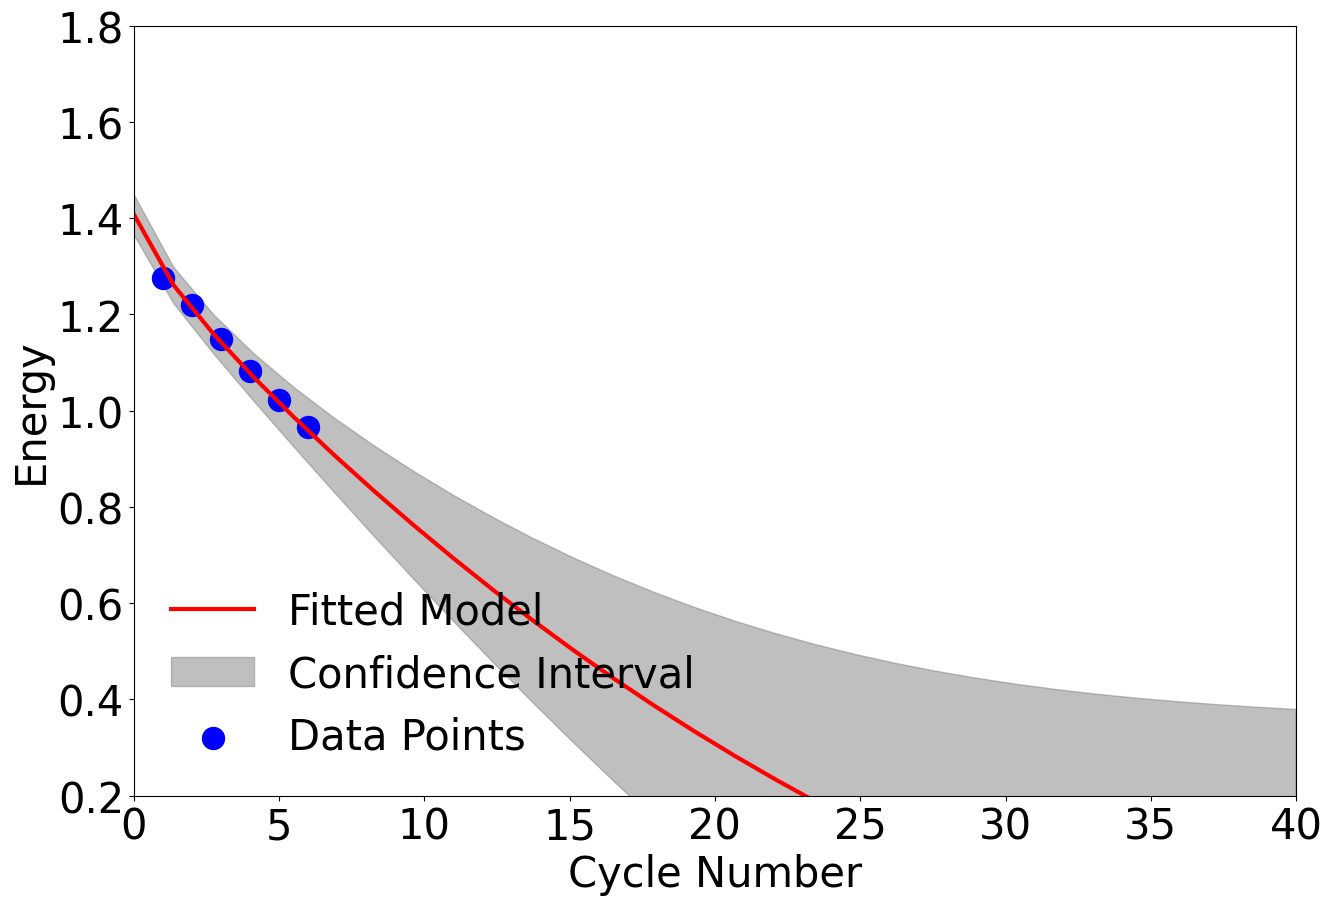

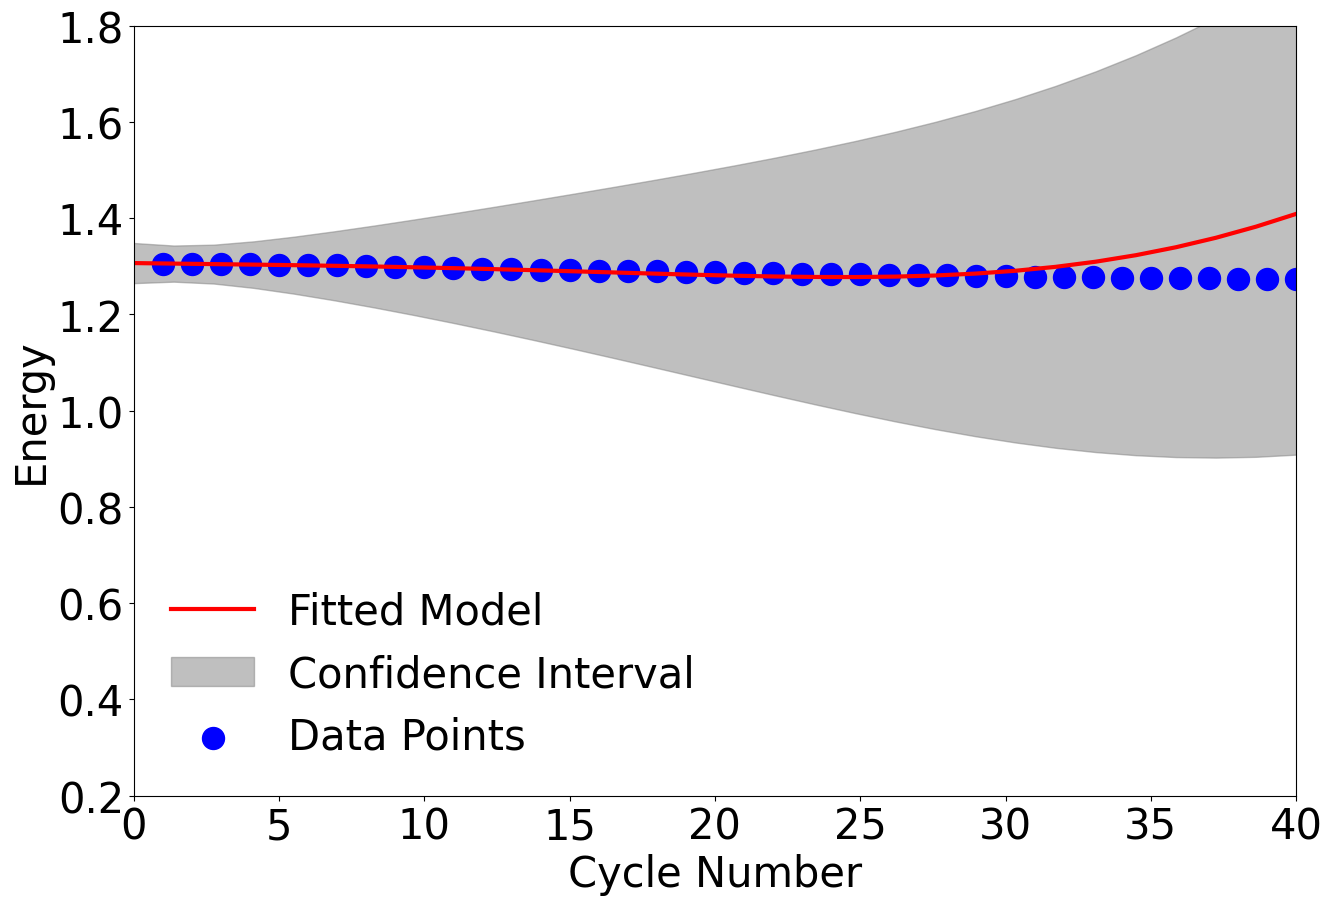

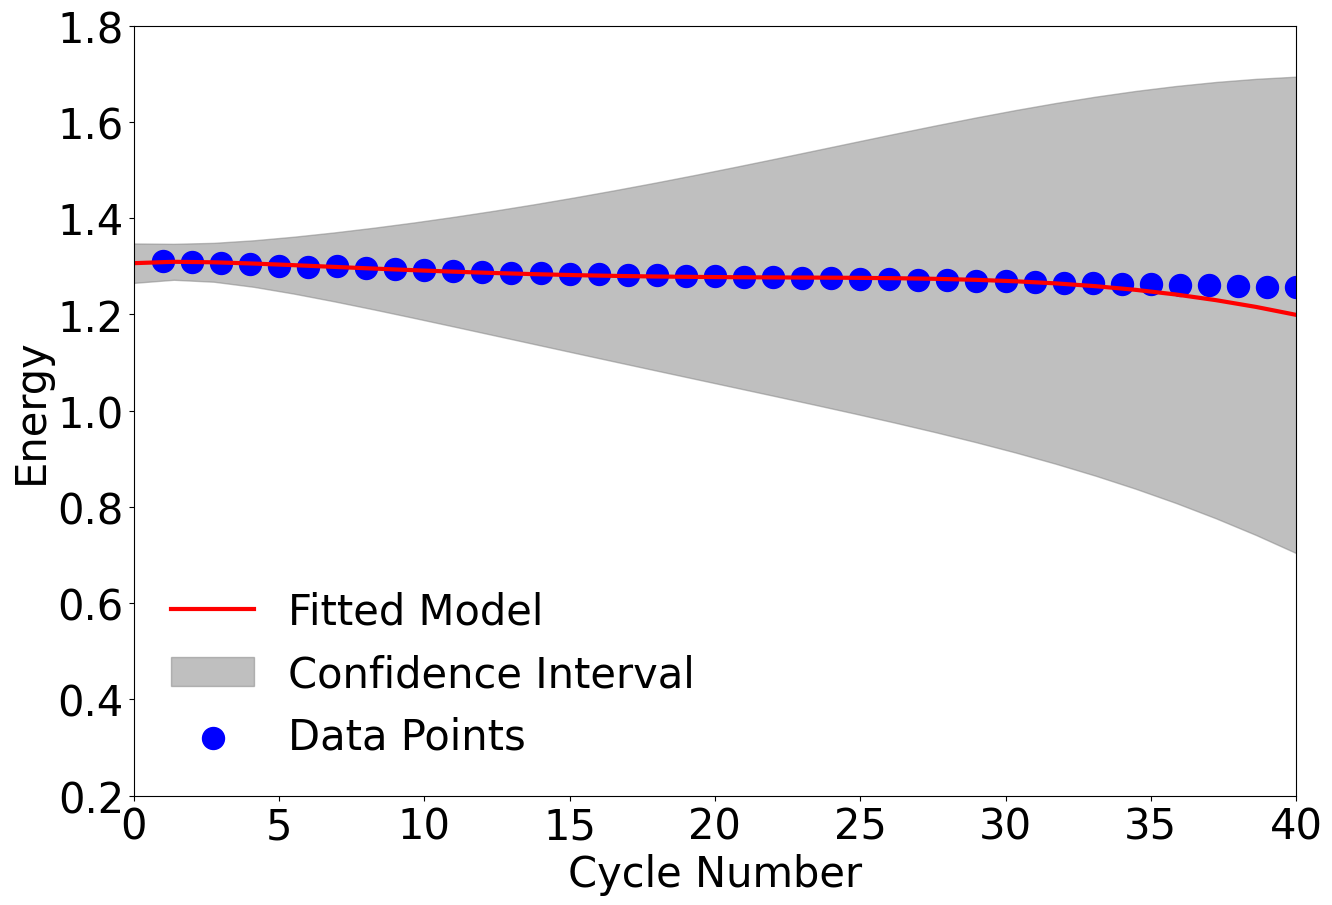

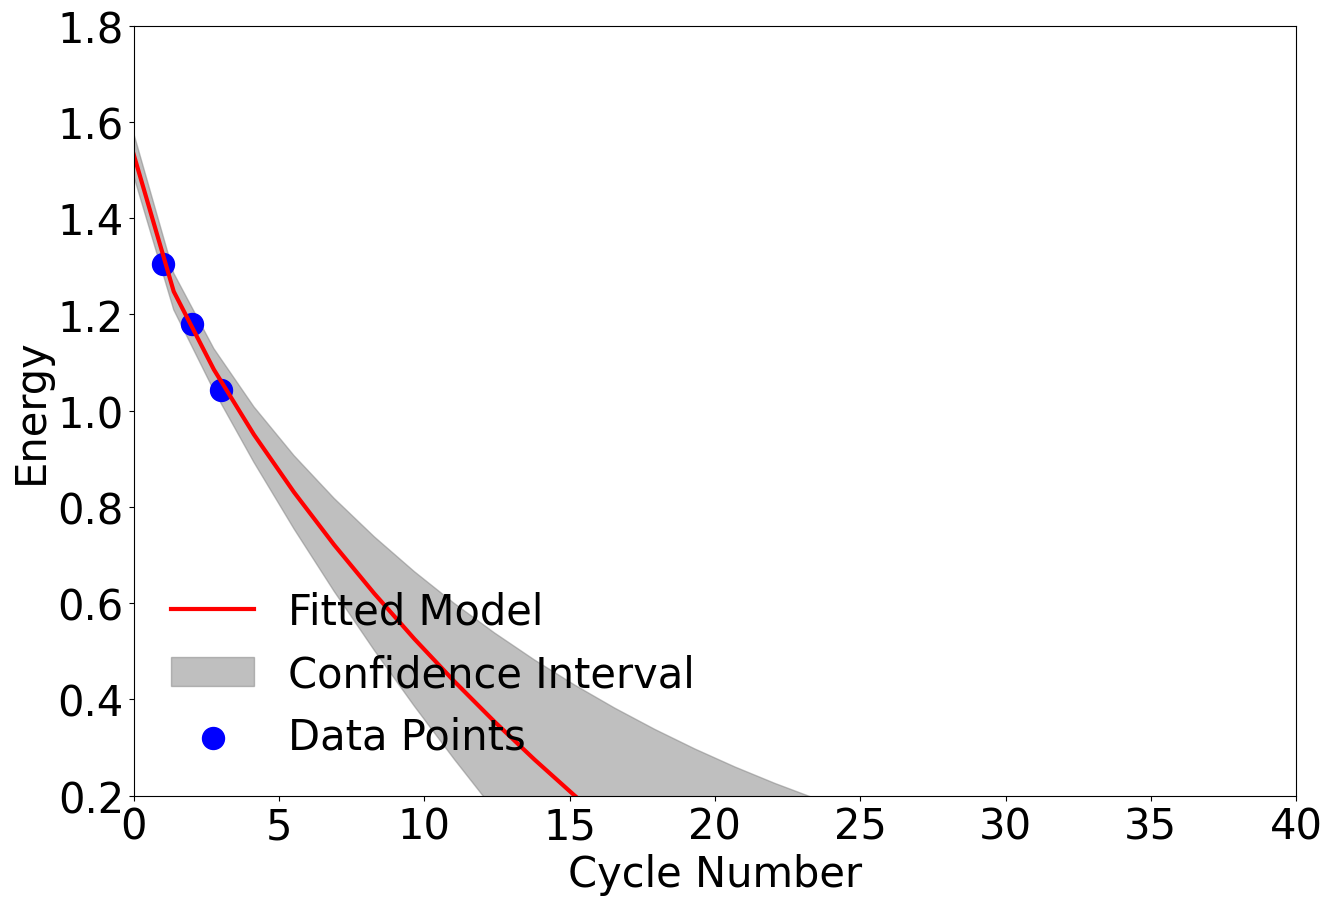

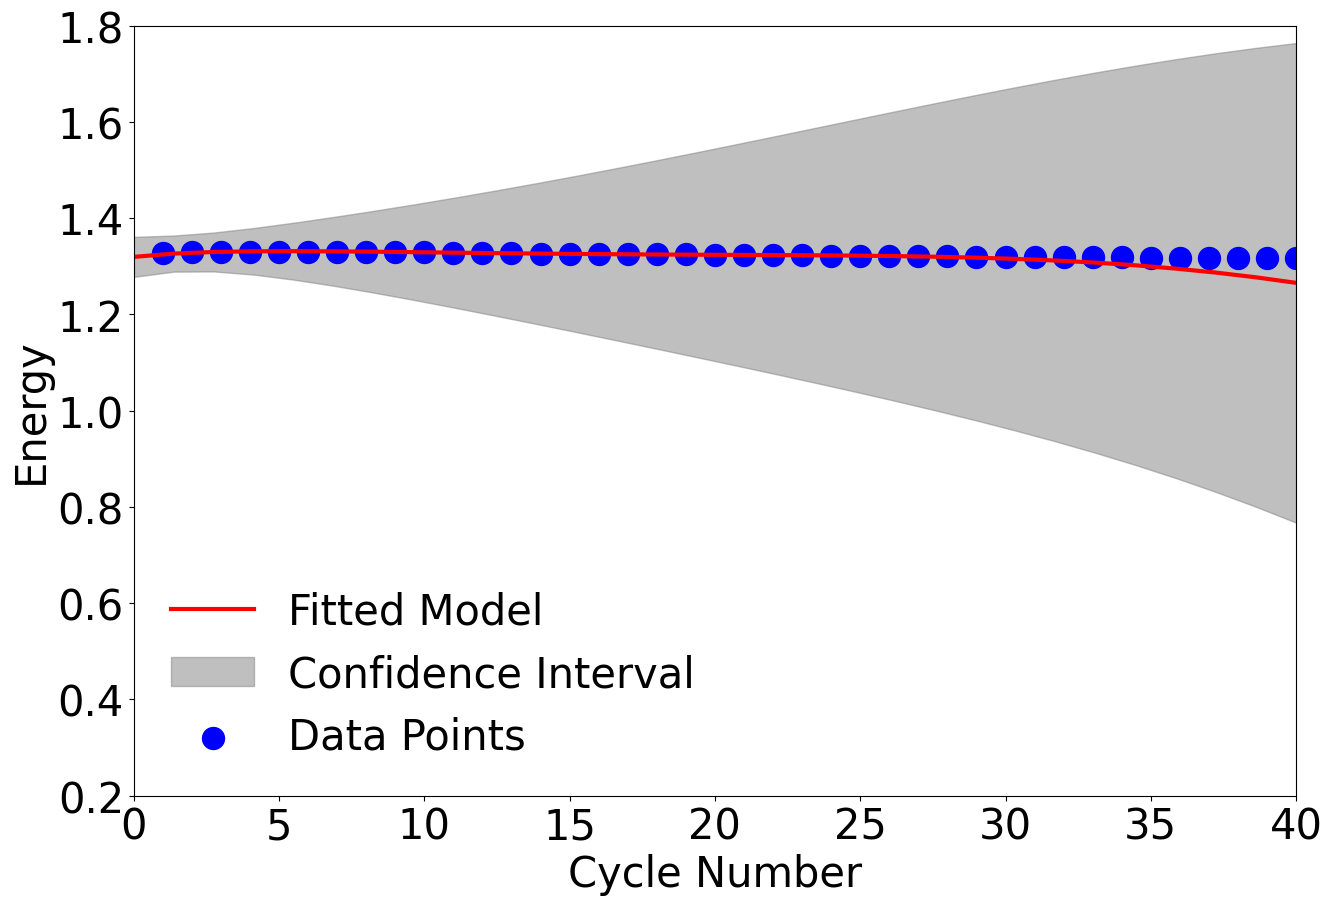

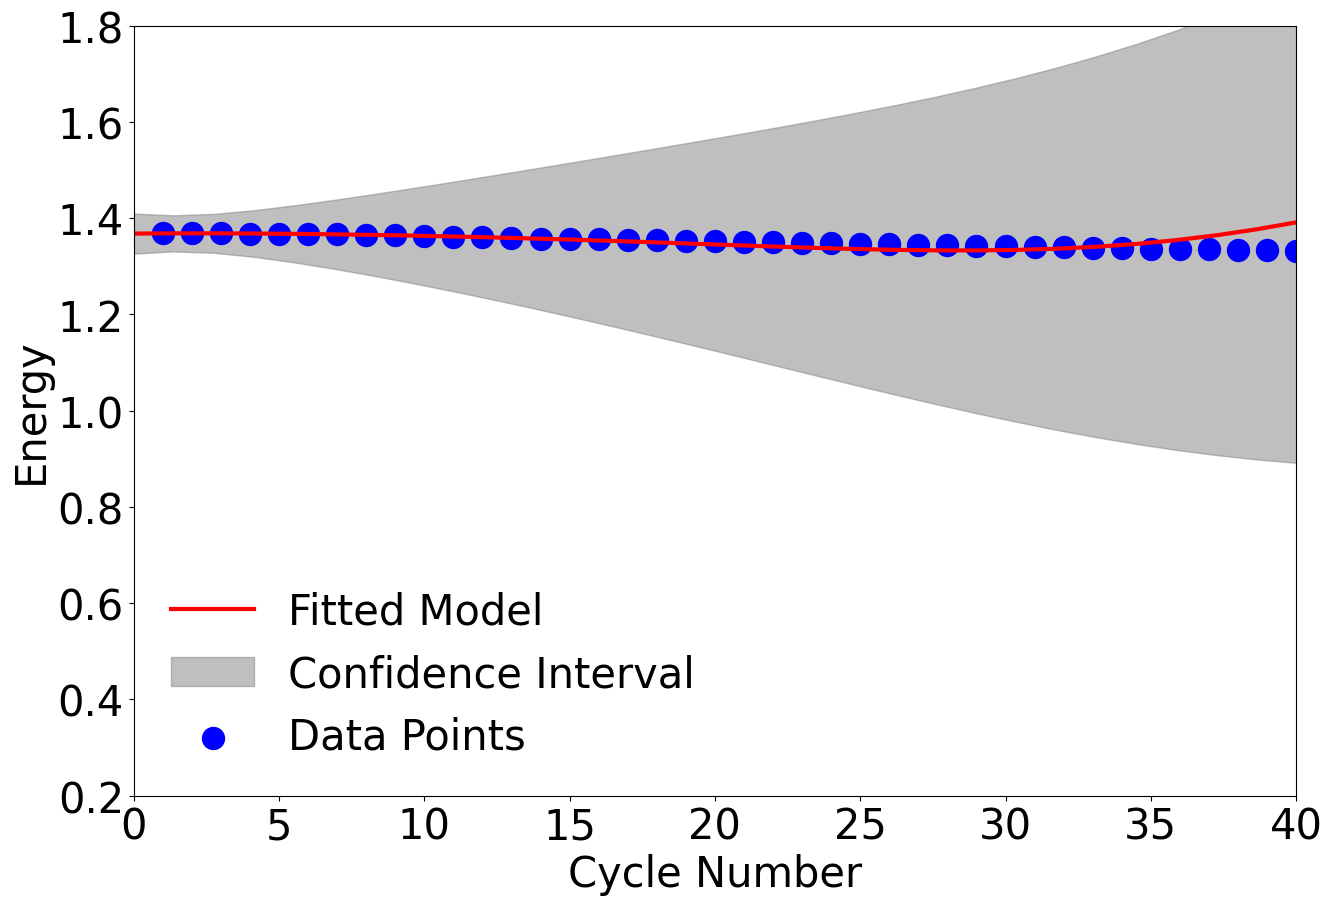

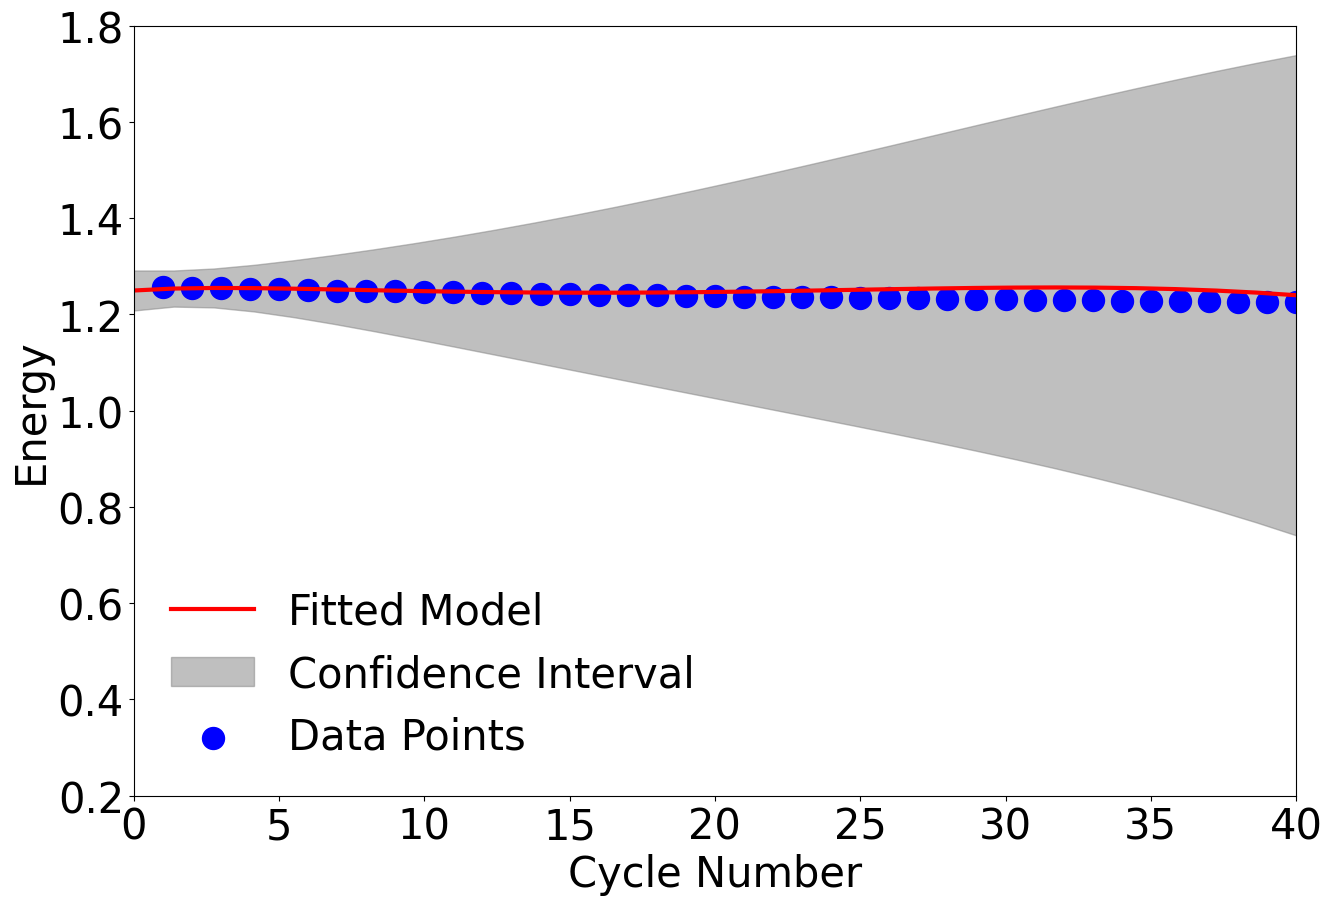

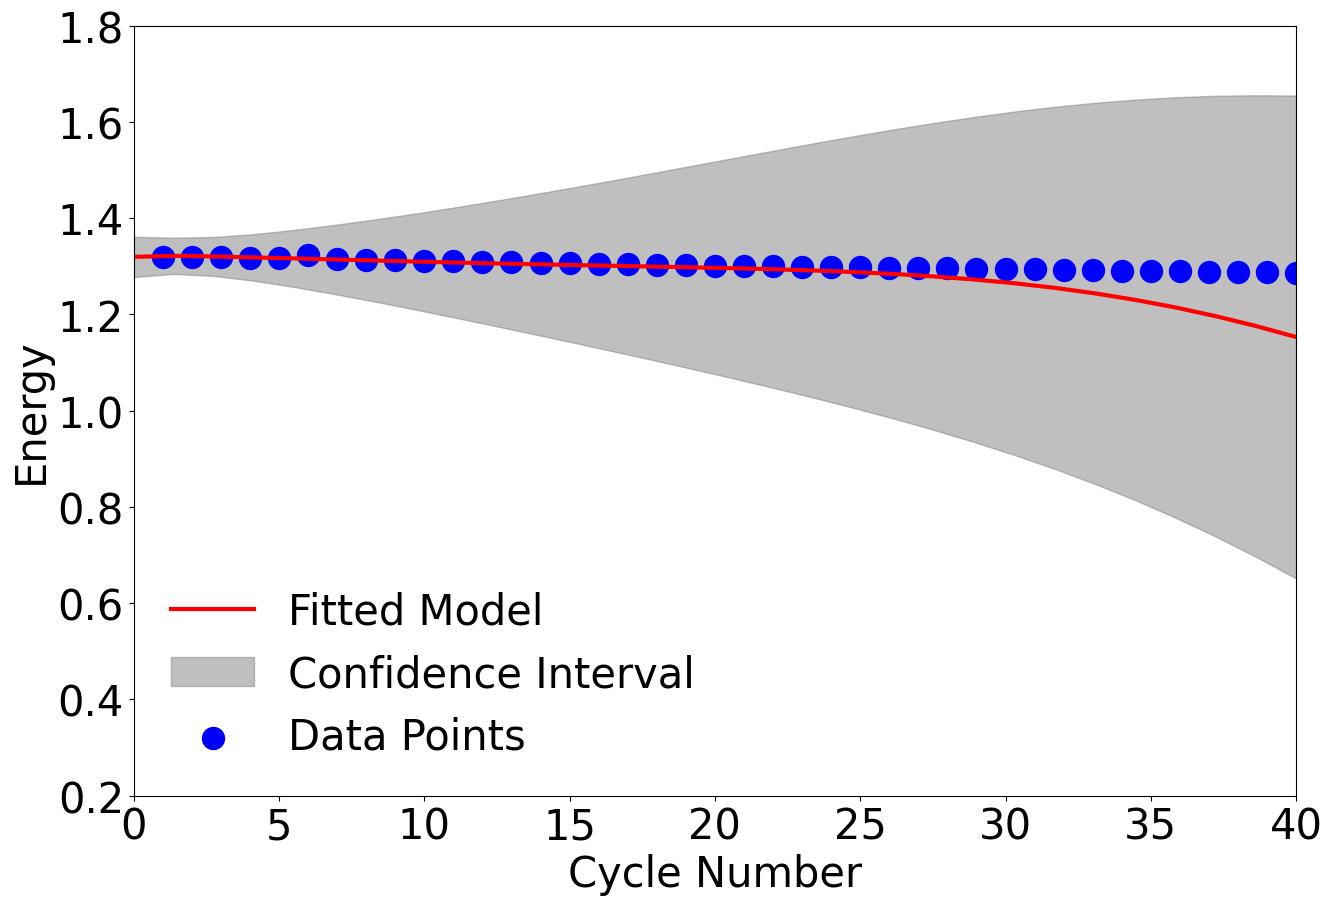

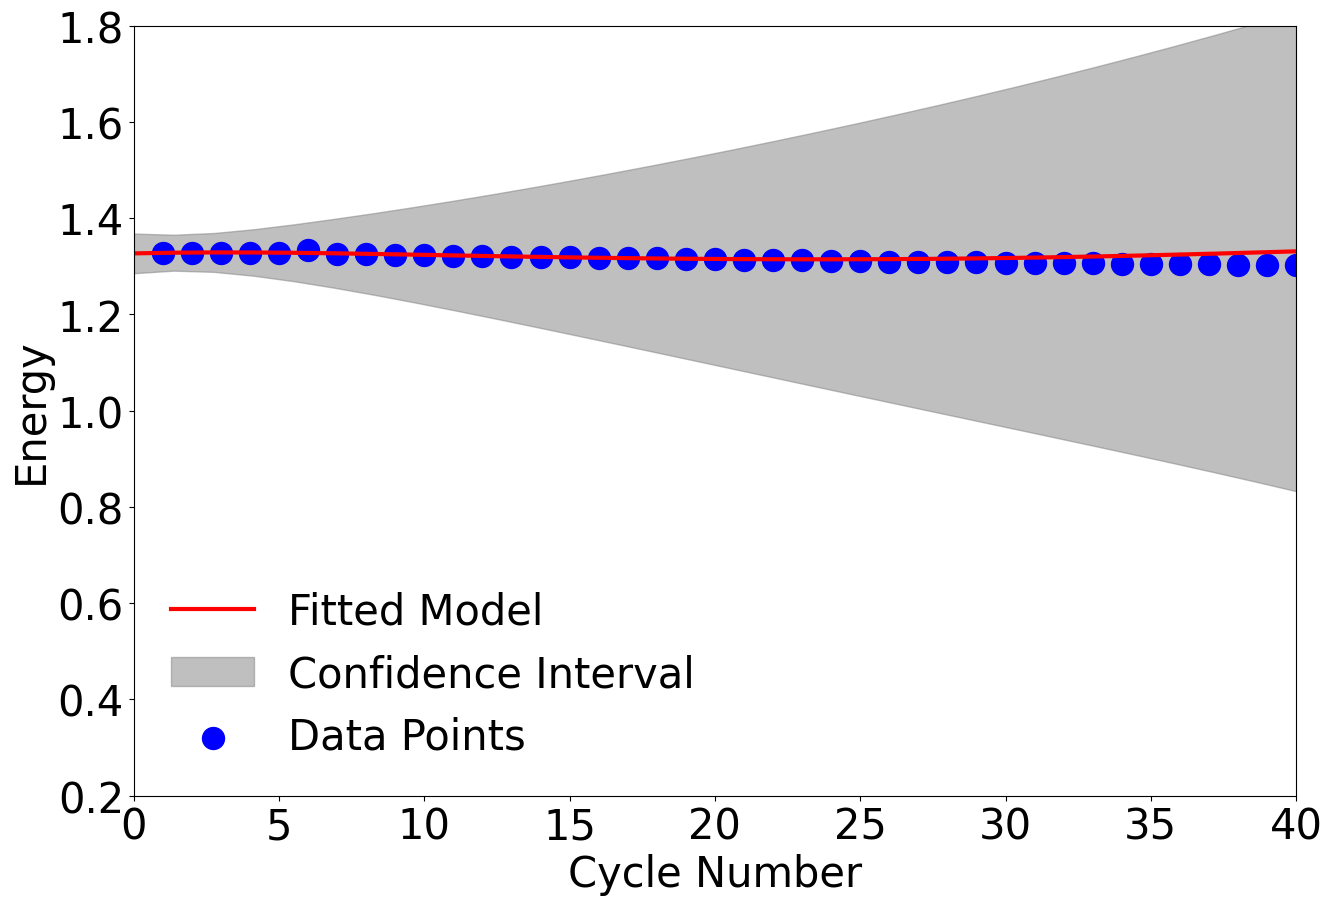

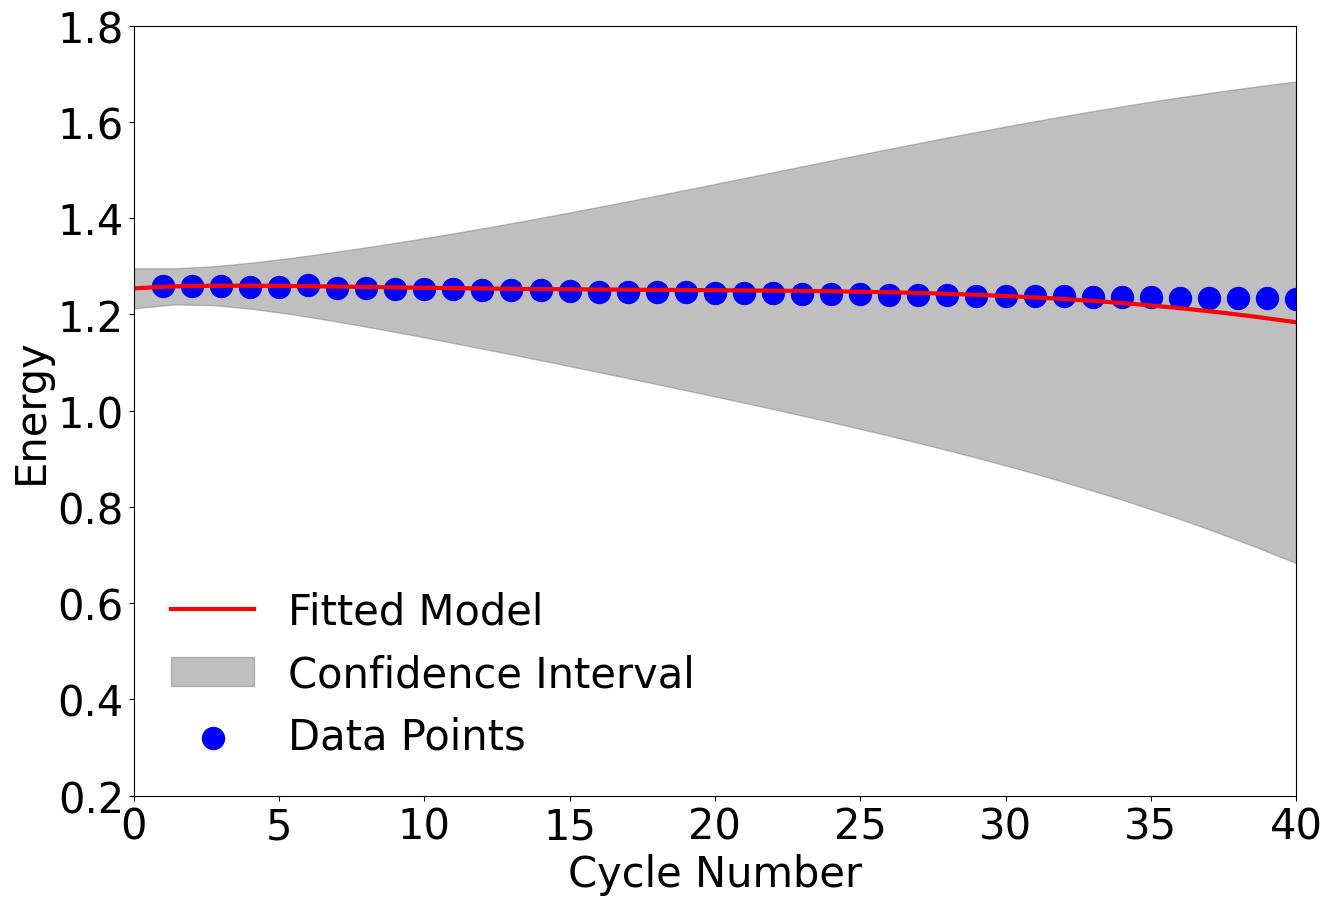

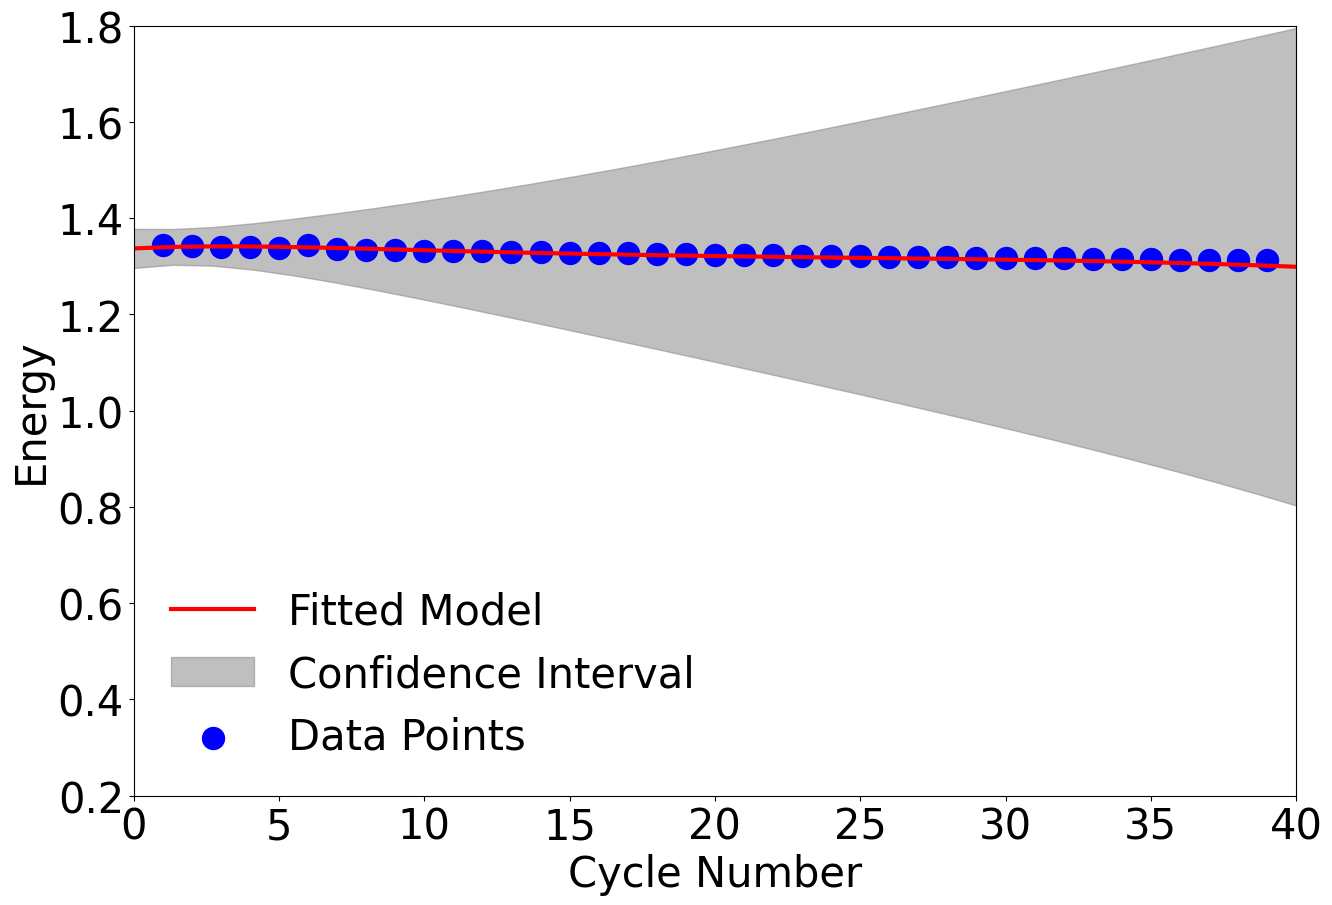

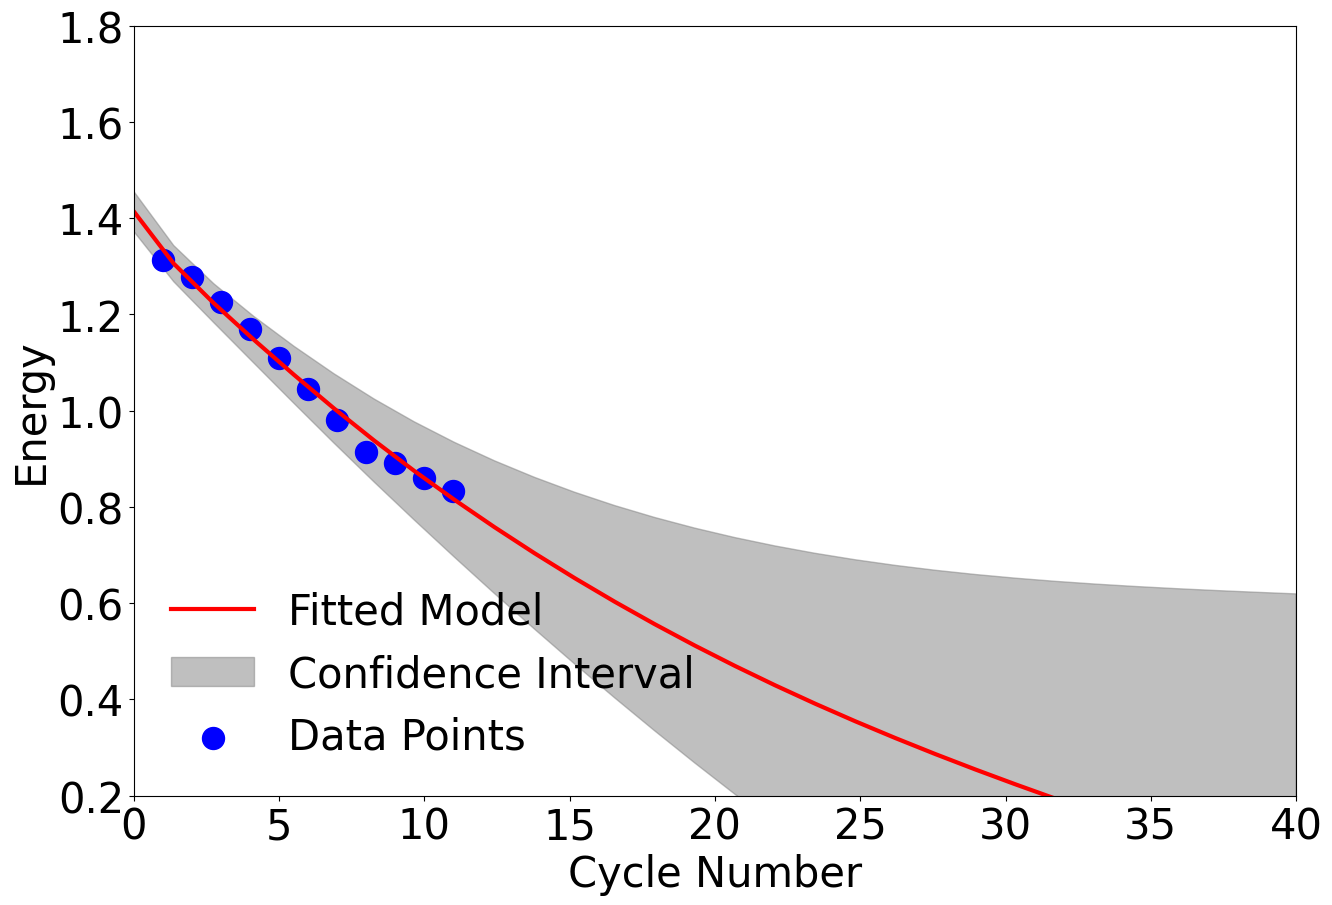

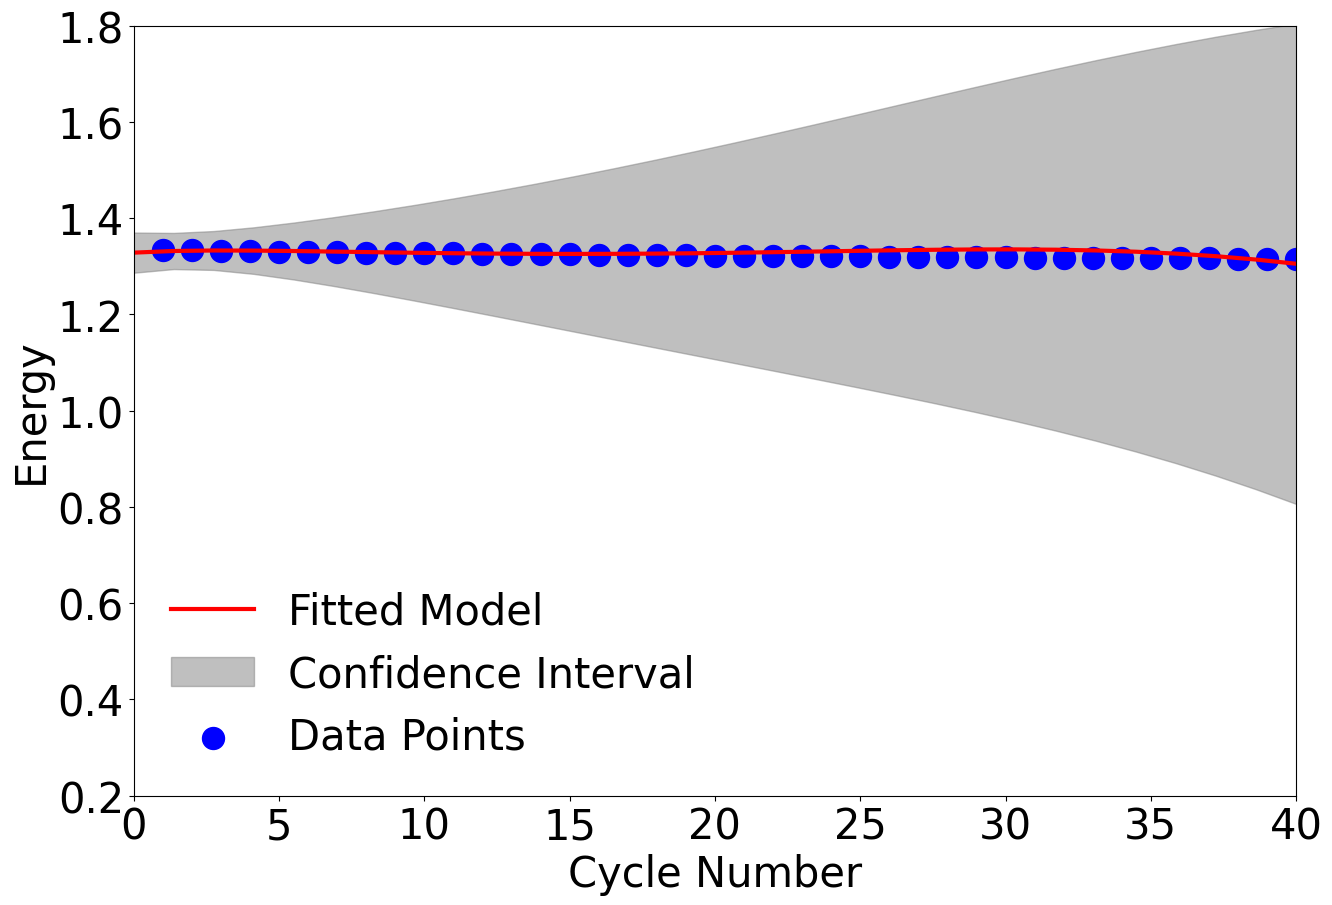

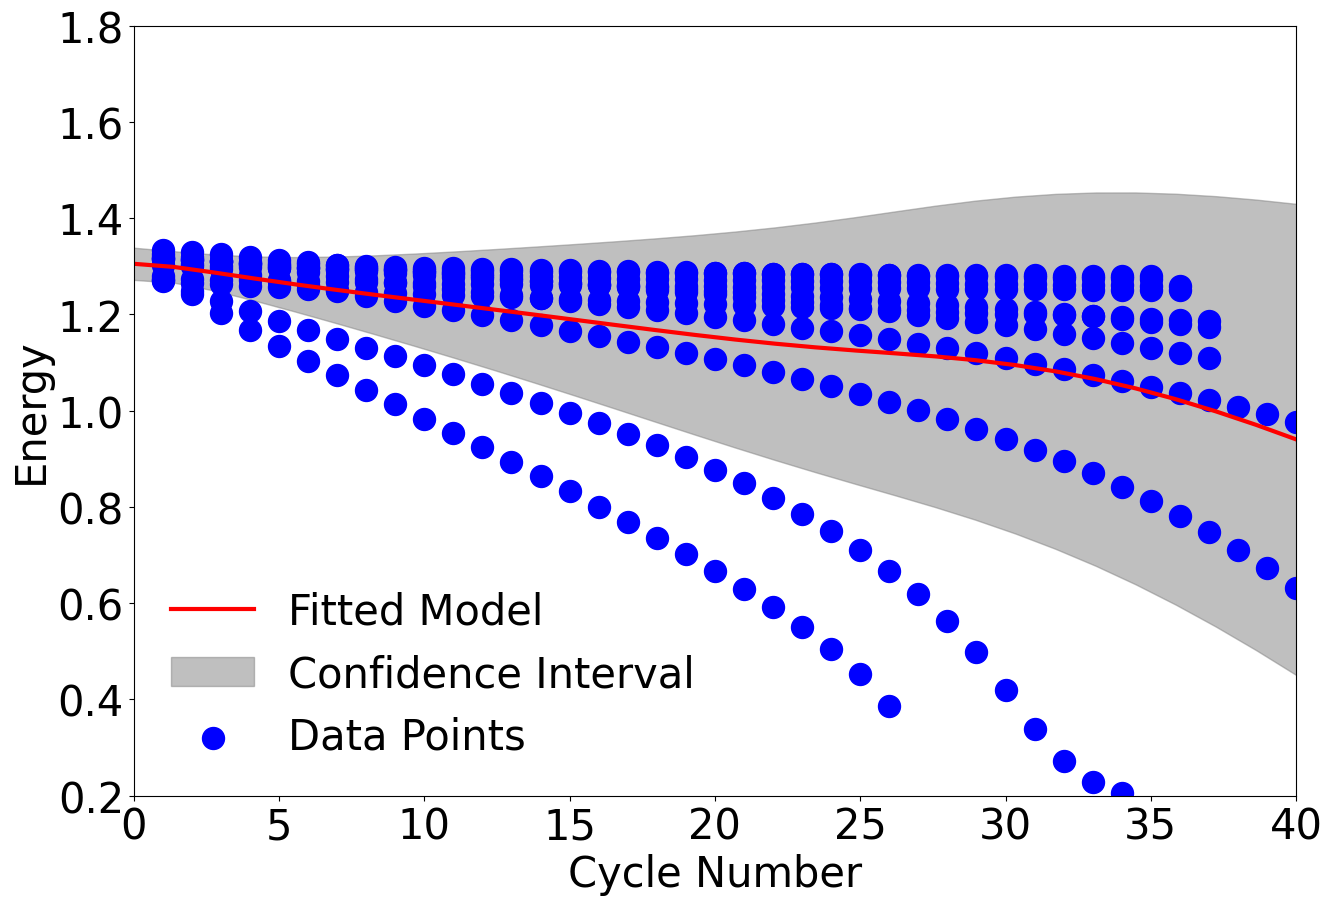

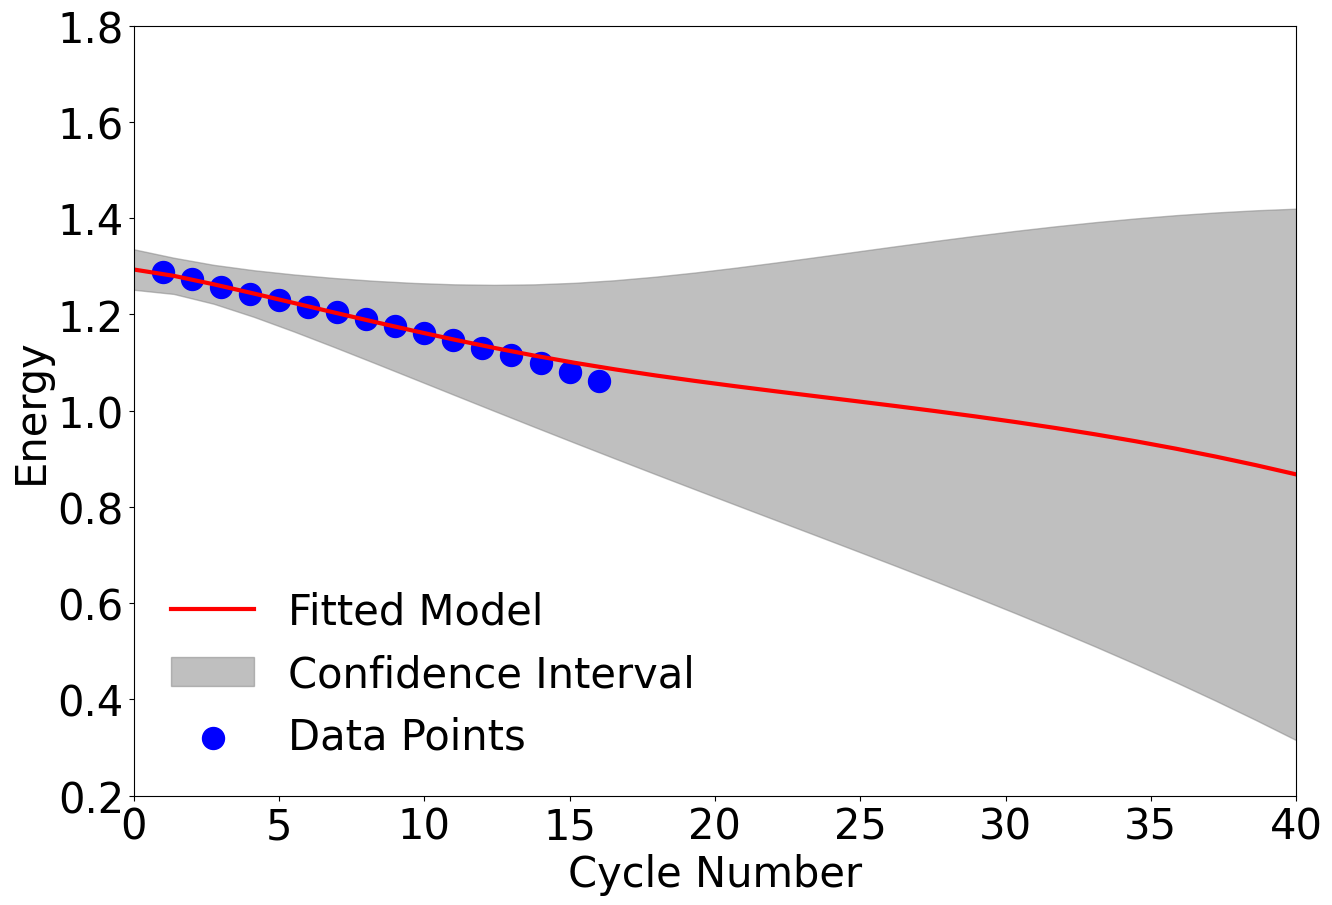

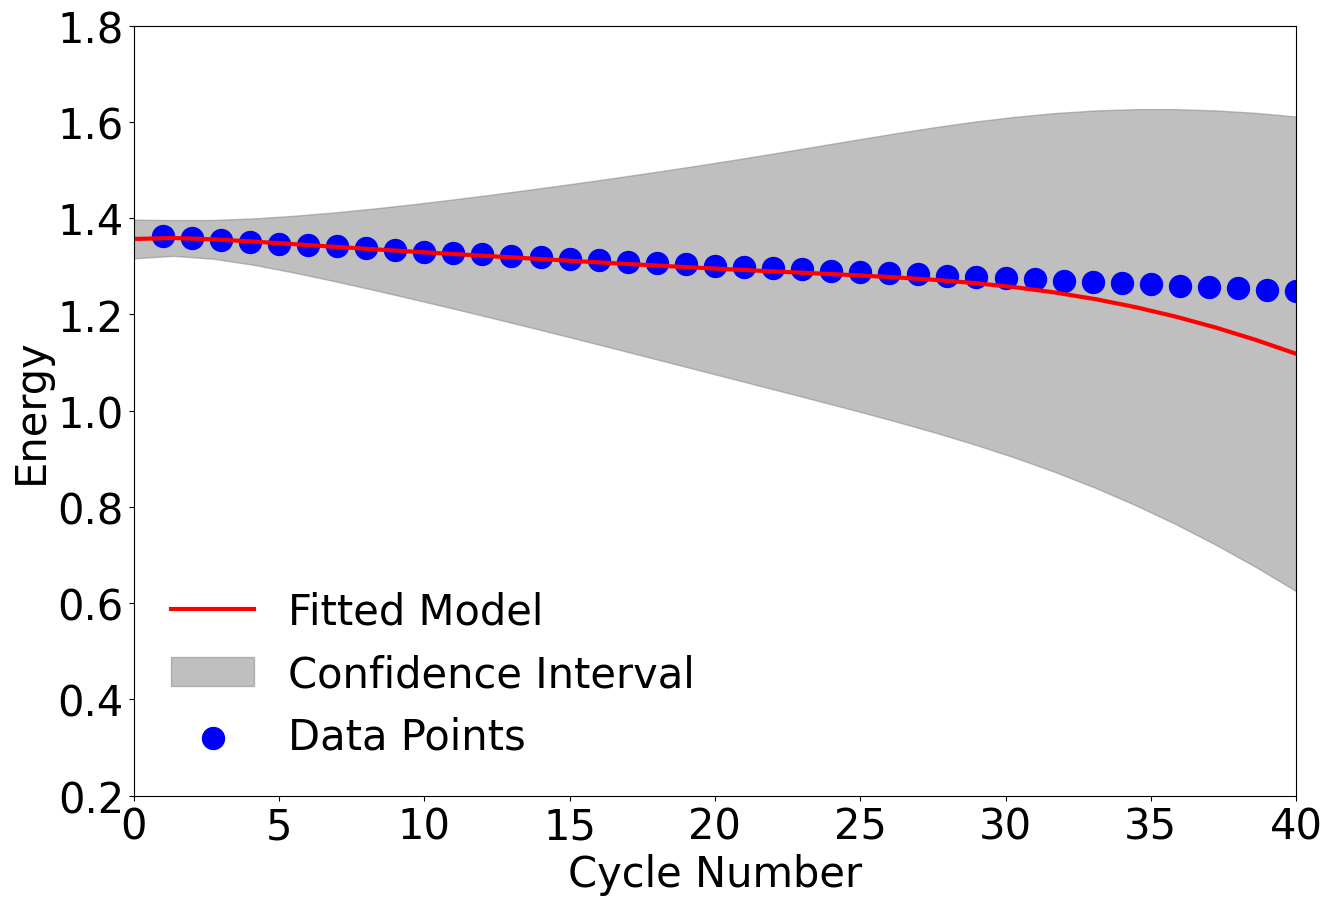

In [16]:
# This is the same as above, but in a more efficient way without calculating the posterior mean 
# and uncertainty in the whole space

crate_soc_data_285 = np.array([[4.08,55],[3.29,32.5],[4.73,75],[6.6,25],[3,55],[3.89,52.5],[6.13,37.5],[2.07,20],[2.24,37.5],[3.2,70],[4.16,22.5],[5.77,27.5],[3.9,77.5],[6.03,35],[4.44,50] ,[6.1,52.5]])
crate_soc_data_288 = np.array([[3.53,56.04],[2.47,27.04],[4.9,51.85],[6.1,38.14],[7.21,47.72],[5.77,45.6],[7.68,34.8],[2.62,29.84],[3.28,52.23],[5.22,45.99],[6.05,71.24],[3.48,27.63],[2.43,39.43],[3.22,78.47],[7.81,71.74],[3.78,41.34]])
crate_soc_data_291 = np.array([[6.88,75],[2.36,25],[6.52,27.5],[7.92,72.5],[5.32,37.5],[3.06,22.5],[4.52,45],[5.1,62.5],[2.02,62.5],[2.82,75],[2.2,67.5],[6.32,77.5],[6.09,20],[7.46,30],[4.19,80],[7.32,25]])

label_size =30

for i in range(16):
    index_of_interest = i

    soc_of_interest = crate_soc_data_291[index_of_interest,1]
    crate_of_interest = crate_soc_data_291[index_of_interest,0]
    temp_of_interest = 291

    #########################################################
    
    # Define the repeated entries for the first three columns
    repeated_entries = np.array([[soc_of_interest, crate_of_interest, temp_of_interest]])

    # Repeat the entries to match the number of rows
    first_three_columns = np.tile(repeated_entries, (n, 1))

    # Create the fourth column using np.linspace
    fourth_column = np.linspace(loop_low, loop_high, n).reshape(-1, 1)

    # Combine the first three columns with the fourth column
    my_modified_space = np.hstack((first_three_columns, fourth_column))

    my_modified_space_normalized = scaler.transform(my_modified_space)
    
    #########################################################
    
    pred_mean = my_gpo_a.posterior_mean(my_modified_space_normalized)["f(x)"]

    #pred_mean =  mean2(my_modified_space_normalized,my_gpo_a.hyperparameters,my_gpo_a)
    
    pred_uncertainty = my_gpo_a.posterior_covariance(my_modified_space_normalized, add_noise=True)["v(x)"]

    #########################################################
    
    my_indices = np.where((x_data[:,0] == soc_of_interest) & (x_data[:,1] == crate_of_interest) & (x_data[:,2] == temp_of_interest))
    x_data_to_be_plotted = x_data[my_indices[0],3]
    y_data_to_be_plotted = y_data[my_indices[0]]

    #######################################################################
    # Plotting the data
    plt.figure(figsize = (15,10))
    plt.plot(fourth_column[:,0],pred_mean, color = "red", linewidth = 3,label='Fitted Model')
    plt.fill_between(fourth_column[:,0],pred_mean - 2. * np.sqrt(pred_uncertainty), pred_mean + 2. * np.sqrt(pred_uncertainty), alpha = 0.5, color = "grey", label='Confidence Interval')
    plt.scatter(x_data_to_be_plotted,y_data_to_be_plotted, color = "blue",s = 250, label='Data Points') # Training Data
    plt.xlabel("Cycle Number",fontsize=label_size) 
    plt.ylabel("Energy",fontsize=label_size)
    plt.ylim(0.2,1.8)
    #plt.yticks([150, 200, 250, 300, 350])
    plt.xlim(0,40)
    #plt.xticks([0,150,300,450,600])
    plt.legend(fontsize=label_size,frameon=False,loc='lower left')
    plt.tick_params(axis='both', which='major', labelsize=label_size) # Set the font size of the tick labels on the x and y axes
    plt.show()

In [17]:
# Log marginal Likelihood
gp_likelihood = my_gpo_a.log_likelihood()

print("Likelihood: ", gp_likelihood)


Likelihood:  1649.5890582460333


# Sequence of Removing a cell at a time and Testing Performance

In [10]:
# Create the folder for the cross validation
new_folder_path = f"Cross Validation Mean Powerlaw Noise Powerlaw Kernel NonStationary"
os.makedirs(new_folder_path, exist_ok=True)

%cd {new_folder_path}

label_size = 30

my_trained_hps = np.array([ 9.60842288e-01,  6.58185328e-01,  1.89253346e+00,  1.95602323e+00,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.89887276e-02,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.89887276e-02,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.89887276e-02,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.89887276e-02,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.89887276e-02,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.89887276e-02,
        1.89887276e-02,  1.89887276e-02,  1.89887276e-02,  1.00000000e+03,
        5.78123732e-02,  2.35746206e+00,  2.34095692e-04, -1.07438838e+00,
       -1.92472227e+00,  1.17474211e+00, -4.99687389e-01, -8.11738649e-01,
       -9.82989645e-01,  1.39792828e-01,  2.16174759e+00,  1.32022860e-02,
        3.78828379e-01,  1.21388861e-01,  1.26377924e+00])

# Now, you can find unique rows based on these combinations
unique_rows = combined_data.drop_duplicates(subset='Cell ID')
    

# Number of cells that I want to remove from training to be then used in testing
num_of_cells_to_test = 1

# Splitting dataset to training and testing

########
# Old way... Problematic because it results in repetitive results
#np.random.seed(42)  
#random_index_all = np.random.randint(0, len(unique_rows),size=50)
########

# Another method for random indices to ensure no repetitions, for now I am not using it
#random.seed(42)
#unique_random_numbers = random.sample(range(0, len(unique_rows)), 50)

my_ind_to_run = np.array([1,2,7,10,14,18,20,21,22,23,28,29,35,38,39,42,43,51,52,57])


with open("Prediction_Fitness.csv", 'w', newline='') as file:
    writer = csv.writer(file)
    headers = ['Counter', 'Removed Cell', 'Size of Removed Cell', 'Log Likelihood', 'RMSE', 'CRPS']
    writer.writerow(headers)

if os.path.exists("Trained Hyperparameters.csv"):
    # Delete the file
    os.remove("Trained Hyperparameters.csv")
    
my_counter = 0

for my_ind in my_ind_to_run:
    
    print("Removed Cell ID: ", my_ind)
    print("Trial: ", my_counter)

    random_index = my_ind #  random_index_all[my_counter] # np.random.randint(0, len(unique_rows),size=num_of_cells_to_test)
    specific_set = unique_rows.iloc[random_index]['Cell ID']

    # If specific_set is a pandas Series (multiple values), convert it to a list
    if isinstance(specific_set, pd.Series):
        specific_set = specific_set.tolist()
    elif not isinstance(specific_set, list):  # Ensure specific_set is always a list
        specific_set = [specific_set]

    #######################################
    # Extracting Testing Data:
    # Filter testing_data for rows where 'unique_combination' matches any in specific_set
    testing_data = combined_data[combined_data['Cell ID'].isin(specific_set)]

    # Extract the data columns
    loop_number = testing_data['Loop Number'].to_numpy()
    c_rate = testing_data['C-rate'].to_numpy()
    soc = testing_data['SOC [%]'].to_numpy()
    temp = testing_data['Temperature (K)'].to_numpy()
    discharge_energy = testing_data['Discharge Energy (Wh)'].to_numpy()

    # Create the x_data and y_data arrays
    x_data_testing_all = np.column_stack((soc, c_rate, temp, loop_number))
    y_data_testing_all = np.array(discharge_energy)

    # Removing the data where the Discharge Energy is 0
    condition = y_data_testing_all > 0.08
    x_data_testing = np.array(x_data_testing_all[condition,:])
    y_data_testing = np.array(y_data_testing_all[condition])

    ## Assuming x_data and y_data are already defined
    #condition = x_data_testing[:, 3] <= 40 
    #x_data_testing = x_data_testing[condition]
    #y_data_testing = y_data_testing[condition]
    
    # Transform the data
    x_data_testing_normalized = scaler.transform(x_data_testing)

    #######################################
    # Extracting Training Data:
    # Filter training_data for rows where 'unique_combination' does not match any in specific_set
    training_data = combined_data[~combined_data['Cell ID'].isin(specific_set)]

    # Extract the data columns
    loop_number = training_data['Loop Number'].to_numpy()
    c_rate = training_data['C-rate'].to_numpy()
    soc = training_data['SOC [%]'].to_numpy()
    temp = training_data['Temperature (K)'].to_numpy()
    discharge_energy = training_data['Discharge Energy (Wh)'].to_numpy()

    # Create the x_data and y_data arrays
    x_data_training_all = np.column_stack((soc, c_rate, temp, loop_number))
    y_data_training_all = np.array(discharge_energy)

    # Removing the data where the Discharge Energy is 0
    condition = y_data_training_all > 0.08
    x_data_training = np.array(x_data_training_all[condition,:])
    y_data_training = np.array(y_data_training_all[condition])

    # Assuming x_data and y_data are already defined
    #condition = x_data_training[:, 3] <= 40 
    #x_data_training = x_data_training[condition]
    #y_data_training = y_data_training[condition]
    
    # Transform the data
    x_data_trainging_normalized = scaler.transform(x_data_training)

    #######################################
    # GP Modeling

    my_gpo_PartialData = GPOptimizer(x_data_trainging_normalized,y_data_training,
                         init_hyperparameters = my_trained_hps,  # we need enough of those for kernel, noise and prior mean functions
                         hyperparameter_bounds = bounds,
                         #noise_variances=np.ones(y_data_training.shape) * 0.001, #provding noise variances and a noise function will raise a warning 
                         compute_device='cpu', 
                         gp_kernel_function=my_seperable_kernel, 
                         gp_mean_function=mean2, 
                         gp_noise_function=my_noise,
                         args =np.array([n_k_hps,n_n_hps,n_t]))


    my_gpo_PartialData.train(hyperparameter_bounds =bounds, init_hyperparameters = my_trained_hps, method='mcmc',max_iter = 10000)

    print("Training Complete")

    # Saving Trained Hyperparameters
    row_hyperparameters = [my_counter] +  list(my_gpo_PartialData.hyperparameters)

    # Write the row_entropies to the CSV file
    csv_file = open("Trained Hyperparameters.csv", 'a', newline='')
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(row_hyperparameters)
    csv_file.close() # Close the CSV file
        
    #######################################
    # Prediction Fitness 

    # Log marginal Likelihood
    gp_likelihood = my_gpo_PartialData.log_likelihood()

    # RMSE
    my_rmse = my_gpo_PartialData.rmse(x_data_testing_normalized,y_data_testing)

    # CRPS
    my_crps = my_gpo_PartialData.crps(x_data_testing_normalized,y_data_testing)


    # Create a row with the extracted values
    values_to_write = [my_counter, random_index, len(y_data_testing), gp_likelihood, my_rmse, my_crps]
      
    with open("Prediction_Fitness.csv", 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(values_to_write)
            
    #######################################       
    #######################################
    #######################################
    
    soc_of_interest = x_data_testing[0,0]
    crate_of_interest = x_data_testing[0,1]
    temp_of_interest = x_data_testing[0,2]

    
    # Define the repeated entries for the first three columns
    repeated_entries = np.array([[soc_of_interest, crate_of_interest, temp_of_interest]])

    # Repeat the entries to match the number of rows
    first_three_columns = np.tile(repeated_entries, (n, 1))

    # Create the fourth column using np.linspace
    fourth_column = np.linspace(loop_low, loop_high, n).reshape(-1, 1)

    # Combine the first three columns with the fourth column
    my_modified_space = np.hstack((first_three_columns, fourth_column))

    my_modified_space_normalized = scaler.transform(my_modified_space)
    
    #########################################################
    
    pred_mean = my_gpo_PartialData.posterior_mean(my_modified_space_normalized)["f(x)"]

    pred_uncertainty = my_gpo_PartialData.posterior_covariance(my_modified_space_normalized, add_noise=True)["v(x)"]

    #######################################################################

    # Data points
    x_data_to_be_plotted = x_data_testing[:,3]
    y_data_to_be_plotted = y_data_testing
    
    #######################################################################

    # Plotting the data
    plt.figure(figsize = (15,10))
    plt.plot(fourth_column[:,0],pred_mean, color = "red", linewidth = 3,label='Fitted Model')
    plt.fill_between(fourth_column[:,0],pred_mean - 2. * np.sqrt(pred_uncertainty), pred_mean + 2. * np.sqrt(pred_uncertainty), alpha = 0.5, color = "grey", label='Confidence Interval')
    plt.scatter(x_data_to_be_plotted,y_data_to_be_plotted, color = "blue",s = 250, label='Data Points') # Training Data
    plt.xlabel("Cycle Number",fontsize=label_size) 
    plt.ylabel("Energy",fontsize=label_size)
    plt.ylim(0.2,1.8)
    plt.xlim(0,40)
    #plt.legend(fontsize=label_size,frameon=False,loc='lower left')
    plt.tick_params(axis='both', which='major', labelsize=label_size) # Set the font size of the tick labels on the x and y axes
    plt.savefig(f"my_plot_{my_counter}.png") # saving plot with a unique name 
    plt.close() 

    my_counter = my_counter+1
    
%cd ..

C:\Users\Maher Alghalayini\Desktop\Fast Validation of Grid Energy\Different GP Models\Cross Validation Mean Powerlaw Noise Powerlaw Kernel NonStationary
Removed Cell ID:  1
Trial:  0


C:\Anaconda3\envs\gpcam_May2024\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Training Complete
Removed Cell ID:  2
Trial:  1
Training Complete
Removed Cell ID:  7
Trial:  2
Training Complete
Removed Cell ID:  10
Trial:  3
Training Complete
Removed Cell ID:  14
Trial:  4
Training Complete
Removed Cell ID:  18
Trial:  5
Training Complete
Removed Cell ID:  20
Trial:  6
Training Complete
Removed Cell ID:  21
Trial:  7
Training Complete
Removed Cell ID:  22
Trial:  8
Training Complete
Removed Cell ID:  23
Trial:  9
Training Complete
Removed Cell ID:  28
Trial:  10
Training Complete
Removed Cell ID:  29
Trial:  11
Training Complete
Removed Cell ID:  35
Trial:  12
Training Complete
Removed Cell ID:  38
Trial:  13
Training Complete
Removed Cell ID:  39
Trial:  14
Training Complete
Removed Cell ID:  42
Trial:  15
Training Complete
Removed Cell ID:  43
Trial:  16
Training Complete
Removed Cell ID:  51
Trial:  17
Training Complete
Removed Cell ID:  52
Trial:  18
Training Complete
Removed Cell ID:  57
Trial:  19
Training Complete
C:\Users\Maher Alghalayini\Desktop\Fast Val

C:\Anaconda3\envs\gpcam_May2024\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
